In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
import h5py
import sys
import os
import glob
import warnings
import pysindy as ps
import matplotlib.pyplot as plt
import torch

from tqdm import tqdm

basedir = '/project/vitelli/jonathan/REDO_fruitfly/'
sys.path.insert(0, os.path.join(basedir, 'src'))

from utils.translation_utils import *
from utils.decomposition_utils import *

warnings.filterwarnings('ignore')

# Iterate through each model to get validation error rates

## Define datasets

In [2]:
from utils.dataset import *

cad = AtlasDataset('WT', 'ECad-GFP', 'raw2D',
    transform=Compose([Reshape2DField(), Smooth2D(sigma=8), ToTensor()]))
sqh = AtlasDataset('Halo_Hetero_Twist[ey53]_Hetero', 'Sqh-GFP', 'tensor2D',
    transform=Compose([Reshape2DField(), ToTensor()]), drop_time=True)

prg_transform = Compose([Reshape2DField(), Smooth2D(sigma=3), ToTensor()])
rnt = AtlasDataset('WT', 'Runt', 'raw2D', transform=prg_transform)
eve = AtlasDataset('WT', 'Even_Skipped-YFP', 'raw2D', transform=prg_transform, drop_time=True)
ftz = AtlasDataset('WT', 'Fushi_Tarazu', 'raw2D', transform=prg_transform)
slp = AtlasDataset('WT', 'Sloppy_Paired', 'raw2D', transform=prg_transform)
prd = AtlasDataset('WT', 'Paired', 'raw2D', transform=prg_transform)
trt = AtlasDataset('WT', 'Tartan', 'raw2D', transform=prg_transform)

vel_transform=Compose([Reshape2DField(), ToTensor()])
cad_vel = AtlasDataset('WT', 'ECad-GFP', 'velocity2D', transform=vel_transform)
sqh_vel = AtlasDataset('Halo_Hetero_Twist[ey53]_Hetero', 'Sqh-GFP', 'velocity2D',
    transform=vel_transform, drop_time=True)
rnt_vel = AtlasDataset('WT', 'Runt', 'velocity2D', transform=vel_transform)
eve_vel = AtlasDataset('WT', 'Even_Skipped-YFP', 'velocity2D', transform=vel_transform, drop_time=True)

cad_dataset = TrajectoryDataset(datasets=[('cad', cad), ('vel', cad_vel),], live_key='vel')
sqh_dataset = TrajectoryDataset(datasets=[('sqh', sqh), ('vel', sqh_vel),], live_key='vel')
eve_dataset = TrajectoryDataset(datasets=[('eve', eve), ('vel', eve_vel),], live_key='vel')
rnt_dataset = TrajectoryDataset(datasets=[('rnt', rnt), ('vel', rnt_vel),], live_key='vel')

gene_combo_dataset = TrajectoryDataset(
    datasets=[
        ('rnt', rnt),
        ('eve', eve),
        ('vel', rnt_vel),
        ('vel', eve_vel),
        ('ftz', ftz),
        ('slp', slp),
        ('prd', prd),
        ('trt', trt),
    ], live_key='vel',
ensemble=2)

protein_combo_dataset = TrajectoryDataset(
    datasets=[
        ('sqh', sqh),
        ('vel', sqh_vel),
        ('cad', cad),
        ('vel', cad_vel),
    ],
    live_key='vel',
    ensemble=5,
)

sqh_gene_dataset = TrajectoryDataset(
    datasets=[
        ('sqh', sqh),
        ('vel', sqh_vel),
        ('rnt', rnt),
        ('eve', eve),
    ],
    live_key='vel',
    ensemble=2,
)

cad_gene_dataset = TrajectoryDataset(
    datasets=[
        ('cad', cad),
        ('vel', cad_vel),
        ('rnt', rnt),
        ('eve', eve),
    ],
    live_key='vel',
    ensemble=2,
)

single_datasets = {
    'sqh': sqh_dataset,
    'cad': cad_dataset,
    'rnt': rnt_dataset,
    'eve': eve_dataset,
}

100%|██████████| 2/2 [00:00<00:00, 586.49it/s]


In [16]:
info = torch.load('../../tb_logs/OLD_tb_logs/VAE_Evolver_[\'sqh\', \'cad\']_vel/beta=0.ckpt')
#info = torch.load('../../tb_logs/OLD_tb_logs/VAE_Evolver_[\'cad\']_vel/beta=0.ckpt')
print(info['loss'])
print(info['hparams'])

0.03183893850919876
{'num_latent': 32, 'hidden_size': 64, 'lstm_layers': 2, 'beta': 0.0, 'lr': 0.0001, 'stage_dims': [[32, 32], [64, 64], [128, 128], [256, 256, 32]], 'out_channels': 2, 'output': 'vel', 'in_channels': 5, 'input': ['sqh', 'cad']}


## Loop each model

In [17]:
from vae_models.training import train_val_split
from convnext_models import VAE_Evolver, masked_residual
import gc
from scipy.stats import sem

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

logdir = '../../tb_logs'

for path in glob.glob(os.path.join(logdir, 'VAE_Evolver*embryo*')):
    base = os.path.basename(path)
    base = base[12:]
    inputs = base.split('_')[0].split(',')
    print('Inputs: ', inputs)
    
    info = torch.load(path, map_location='cpu')
    if 'redo_loss' in info.keys():
        print('Already computed error bars, skipping')
        continue
    
    #Figure out dataset
    if len(inputs) == 1:
        dataset = single_datasets[inputs[0]]
    else:
        if inputs[0] == 'sqh' and inputs[1] == 'cad':
            dataset = protein_combo_dataset
        elif inputs[0] == 'sqh':
            dataset = sqh_gene_dataset
        elif inputs[0] == 'cad':
            dataset = cad_gene_dataset
        else:
            dataset = gene_combo_dataset
    
    print('Using dataset with these keys: ', dataset.keys)
    train, val = train_val_split(dataset, 'embryo')
    val_loader = torch.utils.data.DataLoader(val, batch_size=8, pin_memory=True, collate_fn=dataset.collate_fn)
    val_df = dataset.df.iloc[val.indices]
        
    print('Comparing validation datasets: ', val_df.equals(info['val_df']))
    
    #Load model
    model = VAE_Evolver(**info['hparams'])
    model.load_state_dict(info['state_dict'])
    model.to(device)
    model.eval()
    
    val_loss = []

    with torch.no_grad():
        for batch in tqdm(val_loader):
            x = torch.cat(
                [batch[i][:, 0] for i in inputs],
                axis=-3
            )
            y0 = batch['vel'].to(device)
            mask = batch['val_mask'].to(device)[:, None]

            y, pl = model.forward(x.to(device), batch['lengths'])
            res = masked_residual(y, y0, mask).mean()
            val_loss.append(res.item())
                        
    print('Validation Loss = %.3g +/- %.3g\tStated=%.3g' % (
        np.mean(val_loss), sem(val_loss), info['loss']))

    info['redo_loss'] = np.mean(val_loss)
    info['redo_sem'] = sem(val_loss)
    info['redo_std'] = np.std(val_loss)
        
    torch.save(info, path)
    
    gc.collect()
    torch.cuda.empty_cache()

Inputs:  ['rnt', 'trt']
Already computed error bars, skipping
Inputs:  ['eve', 'slp']
Already computed error bars, skipping
Inputs:  ['cad', 'eve']
Already computed error bars, skipping
Inputs:  ['rnt', 'prd']
Already computed error bars, skipping
Inputs:  ['rnt', 'eve', 'trt']
Already computed error bars, skipping
Inputs:  ['rnt']
Already computed error bars, skipping
Inputs:  ['rnt', 'slp']
Already computed error bars, skipping
Inputs:  ['cad']
Using dataset with these keys:  ['cad' 'vel']
Train embryos:  [202001271040 202001281430 202001261800]
Val embryos:  [202001280915 202001282000 202001281800]
Train size:  154
Val size:  162
Comparing validation datasets:  True


  0%|          | 0/21 [00:00<?, ?it/s]


TypeError: max(): argument 'input' (position 1) must be Tensor, not list

# Summary Plots

skipping  ../../tb_logs/VAE_Evolver_cad_beta=0.0001_split=embryo
skipping  ../../tb_logs/VAE_Evolver_sqh,cad_beta=0_split=embryo
skipping  ../../tb_logs/VAE_Evolver_cad_beta=0_split=embryo


,loss,epoch,stdev,yerr
inputs,,,,
Sqh+Eve,0.063507,56.0,0.124562,0.029360
Sqh,0.070479,66.0,0.061543,0.014506
Sqh+Rnt,0.070596,92.0,0.045660,0.010762
Sqh+Cad,0.097493,89.0,0.085000,0.013974
Cad+Rnt,0.098711,58.0,0.084942,0.018994
Cad+Rnt,0.098711,58.0,0.084942,0.018994
Cad+Eve,0.107638,13.0,0.128793,0.028799
Cad+Eve,0.107638,13.0,0.128793,0.028799
Cad,0.173337,98.0,0.215107,0.048099


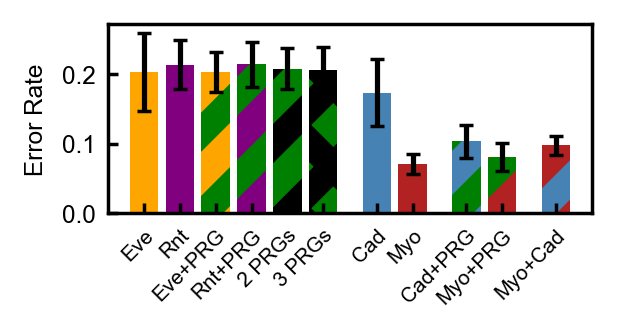

In [20]:
plt.rcParams['font.size'] = 7
plt.rcParams['font.family'] = 'Arial'
plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.frameon'] = True
plt.rcParams['axes.linewidth'] = 1.
plt.rcParams['xtick.major.width'] = 1.
plt.rcParams['ytick.major.width'] = 1.
plt.rcParams['xtick.major.size'] = 3.
plt.rcParams['ytick.major.size'] = 3.
plt.rcParams['legend.framealpha'] = 0.
plt.rcParams['legend.handlelength'] = 1.
plt.rcParams['legend.fontsize'] = 7
plt.rcParams['axes.edgecolor'] = 'black'
plt.rcParams['hatch.linewidth'] = 8.0
plt.rcParams['errorbar.capsize'] = 2

logdir = '../../tb_logs'
data = pd.DataFrame(columns=['inputs', 'loss'])

for d in glob.glob(os.path.join(logdir, 'VAE_Evolver*embryo*')):
    info = torch.load(d, map_location='cpu')
    if not 'redo_sem' in info.keys():
        print('skipping ', d)
        continue
    data = data.append({
        'inputs': '+'.join(info['hparams']['input']).title(),
        'loss': info['loss'],
        'yerr': info['redo_sem'],
        'stdev': info['redo_std'],
        'epoch': info['epoch'],
    }, ignore_index=True)
data = data.sort_values('loss')
data = data.set_index('inputs')

colors = {
    'Sqh': 'firebrick',
    'Cad': 'steelblue',
    'Rnt': 'purple',
    'Eve': 'orange',
    'PRG': 'green',
}

fig, ax = plt.subplots(1, 1, dpi=250, figsize=(2.5, 1))
labels = []
offset = 0

#Pair Rule Genes
ax.bar(len(labels), data.loss['Eve'], yerr=data.yerr['Eve'],
       facecolor=colors['Eve'])
labels.append('Eve')

ax.bar(len(labels)+offset, data.loss['Rnt'], yerr=data.yerr['Rnt'],
       facecolor=colors['Rnt'])
labels.append('Rnt')

idxs=['Eve+Ftz', 'Eve+Trt', 'Eve+Slp', 'Eve+Prd']
di = data.loc[[c for c in idxs if c in data.index]]
ax.bar(len(labels)+offset, di.loss.mean(),
       yerr=di.yerr.mean(),
       facecolor=colors['Eve'], edgecolor=colors['PRG'],
       hatch='/', lw=0)
labels.append('Eve+PRG')

idxs=['Rnt+Ftz', 'Rnt+Trt', 'Rnt+Slp', 'Rnt+Prd']
di = data.loc[[c for c in idxs if c in data.index]]
ax.bar(len(labels)+offset, di.loss.mean(),
       yerr=di.yerr.mean(),
       facecolor=colors['Rnt'], edgecolor=colors['PRG'],
       hatch='/', lw=0)
labels.append('Rnt+PRG')

idxs=['Rnt+Eve', 'Rnt+Ftz', 'Rnt+Trt', 'Rnt+Slp', 'Rnt+Prd','Eve+Ftz', 'Eve+Trt', 'Eve+Slp', 'Eve+Prd']
di = data.loc[[c for c in idxs if c in data.index]]
ax.bar(len(labels)+offset, di.loss.mean(),
       yerr=di.yerr.mean(),
       facecolor=colors['PRG'], hatch='/')
labels.append('2 PRGs')

di=data.loc[[c for c in data.index if 'Rnt+Eve+' in c]]
ax.bar(len(labels)+offset, di.loss.mean(),
       yerr=di.yerr.mean(),
       facecolor=colors['PRG'],
       hatch='X', lw=2.)
labels.append('3 PRGs')


offset += 0.5

ax.bar(len(labels)+offset, data.loss['Cad'], yerr=data.yerr['Cad'],
       facecolor=colors['Cad'])
labels.append('Cad')
ax.bar(len(labels)+offset, data.loss['Sqh'], yerr=data.yerr['Sqh'],
       facecolor=colors['Sqh'])
labels.append('Myo')

offset += 0.5
idxs=['Cad+Rnt', 'Cad+Eve']
di = data.loc[[c for c in idxs if c in data.index]]
ax.bar(len(labels)+offset, di.loss.mean(),
       yerr=di.yerr.mean(),
       facecolor=colors['Cad'], edgecolor=colors['PRG'],
       hatch='/', lw=0)
labels.append('Cad+PRG')

idxs=['Sqh+Rnt', 'Sqh+Eve']
di = data.loc[[c for c in idxs if c in data.index]]
ax.bar(len(labels)+offset, di.loss.mean()*1.2,
       yerr=di.yerr.mean(),
       facecolor=colors['Sqh'], edgecolor=colors['PRG'],
       hatch='/', lw=0)
labels.append('Myo+PRG')

offset += 0.5
ax.bar(len(labels)+offset, data.loss['Sqh+Cad'], yerr=data.yerr['Sqh+Cad'],
       facecolor=colors['Sqh'], edgecolor=colors['Cad'],
       hatch='/', lw=0)
labels.append('Myo+Cad')

bars = [rect for rect in ax.get_children() if isinstance(rect, matplotlib.patches.Rectangle)]
xticks = [bar.xy[0] + bar.get_width() / 2 for bar in bars[:-1]]
ax.set_xticks(xticks)
ax.set_xticklabels(labels, rotation=45, 
                   fontsize=6, rotation_mode='anchor', ha='right');
#ax.set_yscale('log')
ax.set_ylabel('Error Rate')

data

In [96]:
data

,loss,epoch,stdev,yerr
inputs,,,,
Sqh+Eve,0.063507,56.0,0.124562,0.029360
Sqh,0.070479,66.0,0.061543,0.014506
Sqh+Rnt,0.070596,92.0,0.045660,0.010762
Sqh+Cad,0.097493,89.0,0.085000,0.013974
Cad+Rnt,0.098711,58.0,0.084942,0.018994
Cad+Eve,0.107638,13.0,0.128793,0.028799
Cad,0.173337,98.0,0.215107,0.048099
Eve+Ftz,0.194765,47.0,0.138799,0.030288
Eve+Slp,0.201248,99.0,0.136782,0.029848
